#Kaggle-数字识别

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import csv
%matplotlib inline

In [2]:
#读取数据
train_pd = pd.read_csv('data/train.csv')
test_pd = pd.read_csv('data/test.csv')
y,X = train_pd['label'].values,train_pd[train_pd.columns[1:]].values
X_test = test_pd[test_pd.columns].values

In [3]:
#normalize
X_train = normalize(X.astype(np.float32),axis=0)
X_test = normalize(X_test.astype(np.float32),axis=0)

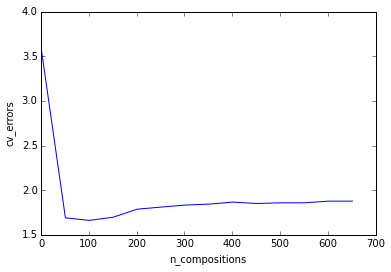

In [17]:
#主成分分析,利用
t0 = time.time()
cv_errors = []
X_pca,y_pca = X_train[:2000,:],y[:2000]#取1000个样本进行主成分维度的选择
k_flod = KFold(X_pca.shape[0],n_folds=10)
n_components = range(1,700,50)
for n_component in n_components:
    pca = PCA(n_components=n_component)
    X_temp = pca.fit_transform(X_pca)
    rmses = []
    for train,test in k_flod:
        Xtrain,ytrain,Xtest,ytest = X_temp[train],y_pca[train],X_temp[test],y_pca[test]
        clf = KNeighborsClassifier(n_neighbors=10).fit(Xtrain,ytrain)
        ypred = clf.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ypred,ytest)))
    cv_errors.append(np.mean(rmses))
t1 = time.time()
plt.plot(n_components,cv_errors)
plt.xlabel('n_compositions')
plt.ylabel('cv_errors')

In [4]:
#因此将数据压缩至50维以增加训练的速度
pca = PCA(n_components=100)
X_train_final = pca.fit_transform(X_train)
X_test_final = pca.fit_transform(X_test)
X_train_final.shape,X_test_final.shape

((42000, 100), (28000, 100))

In [5]:
t2 = time.time()
clf = KNeighborsClassifier(n_neighbors=10,weights='distance',algorithm='kd_tree')
clf.fit(X_train_final,y)
t3 = time.time()
print("用时%.2f秒"%(t3-t2))

用时0.33秒


In [6]:
#预测
t4=time.time()
ypred = clf.predict(X_test_final)
t5=time.time()
print("用时%.2f秒"%(t5-t4))

用时376.31秒


In [7]:
#保存结果
with open("result0.csv","w",newline ='') as f:
    writer = csv.writer(f)
    writer.writerow(['ImageId','label'])
    for i,number in enumerate(ypred):
        writer.writerow([i+1,number])
    f.close()

In [49]:
##精确率太低

In [52]:
##利用随机森林算法再试验
rfc = RandomForestClassifier(n_estimators=500,max_features='sqrt',oob_score=True)

In [53]:
t6= time.time()
ypred = rfc.fit(X_train,y)
t7 = time.time()
print("用时%.2f秒"%(t7-t6))

用时148.74秒


In [54]:
t8 = time.time()
ypred1 = rfc.predict(X_test)
t9 = time.time()
t9-t8

5.282764911651611

In [56]:
with open("result1.csv","w",newline ='') as f:
    writer = csv.writer(f)
    writer.writerow(['ImageId','label'])
    for i,number in enumerate(ypred1):
        writer.writerow([i+1,number])
    f.close()

###精确度达到0.968，且算法运行的速度很快，考虑利用随机森林和K-flod结合选择降维维度，再重新利用KNN算法

In [4]:
def dimSelection(X,y,n_components):
    cv_errors = []
    k_flod = KFold(X.shape[0],n_folds=10)
    for n_component in n_components:
        pca = PCA(n_components=n_component)
        X_pca = pca.fit_transform(X)
        rmses = []
        for train,test in k_flod:
            Xtrain,ytrain,Xtest,ytest = X_pca[train],y[train],X_pca[test],y[test]
            rfc = RandomForestClassifier(n_estimators=500,max_features='sqrt')
            rfc.fit(Xtrain,ytrain)
            ypred = rfc.predict(Xtest)
            rmses.append(np.sqrt(mean_squared_error(ypred,ytest)))
        cv_errors.append(np.mean(rmses))
        
    plt.plot(n_components,cv_errors)
    plt.xlabel('n_compositions')
    plt.ylabel('cv_errors')
    
    return n_components[cv_errors.index(min(cv_errors))]

In [ ]:
t10 = time.time()
n_components = range(50,700,50)
dim = dimSelection(X_train,y,n_components)
t11 = time.time()
t11-t10